In [1]:
import os
import numpy as np
import pandas as pd

from unidecode import unidecode

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import resample

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from keras.layers import Dropout, Activation, Flatten, Convolution1D, Dropout, Reshape
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
#Define learning rate
lr=0.0001 

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [5]:
!nvidia-smi

Mon Jan 20 09:41:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   44C    P8             17W /  200W |     443MiB /   8192MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import pandas as pd
import glob

path = r'H:/Datasets/cic-ids-2018' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, encoding='cp1252', index_col=None, header=0, low_memory=False)
    li.append(df)
    print("Read Completed for ", filename)
   
  
print("Reading Finished")
df = pd.concat(li, axis=0, ignore_index=True)

#df = df.rename(columns={' Label': 'Label'})

del li

Read Completed for  H:/Datasets/cic-ids-2018\bot_02-03-2018.csv
Read Completed for  H:/Datasets/cic-ids-2018\bruteforce-web-xss_sql-injection_22-02-2018.csv
Read Completed for  H:/Datasets/cic-ids-2018\bruteforce-web-xss_sql-injection_23-02-2018.csv
Read Completed for  H:/Datasets/cic-ids-2018\ddos-loic-udp_hoic_21-02-2018.csv
Read Completed for  H:/Datasets/cic-ids-2018\dos-goldeneye-slowloris_15-02-2018.csv
Read Completed for  H:/Datasets/cic-ids-2018\dos-slowhttp-hulk_16-02-2018.csv
Read Completed for  H:/Datasets/cic-ids-2018\infiltration_01-03-2018.csv
Read Completed for  H:/Datasets/cic-ids-2018\infiltration_28-02-2018.csv
Reading Finished


In [7]:
df.describe()

,dst_port,protocol,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,...,fwd_act_data_pkts,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,...,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06
mean,1.176293e+04,8.178602e+00,1.073036e+07,3.324145e+01,5.742645e+00,1.333921e+03,4.456568e+03,2.376153e+02,9.024902e+00,5.710277e+01,...,2.969893e+01,1.944764e+01,9.569520e+04,4.484061e+04,1.506702e+05,6.705993e+04,5.121205e+06,3.393498e+05,5.633248e+06,4.703578e+06
std,2.079196e+04,4.514253e+00,5.622927e+08,1.868033e+03,1.769811e+02,8.301538e+04,2.506477e+05,3.434789e+02,2.464588e+01,7.015623e+01,...,1.866864e+03,7.896557e+00,1.568348e+06,9.130883e+05,2.079168e+06,1.341667e+06,3.358656e+08,2.075285e+08,7.357827e+08,9.374236e+07
min,0.000000e+00,0.000000e+00,-8.282200e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+01,6.000000e+00,7.460000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.430000e+02,6.000000e+00,1.478900e+04,2.000000e+00,1.000000e+00,4.400000e+01,9.600000e+01,4.100000e+01,0.000000e+00,3.600000e+01,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.080000e+03,6.000000e+00,3.452732e+06,5.000000e+00,4.000000e+00,6.750000e+02,3.550000e+02,3.870000e+02,0.000000e+00,1.027143e+02,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.700000e+01,1.200000e+08,3.096290e+05,1.231180e+05,1.443918e+08,1.563604e+08,6.444000e+04,1.460000e+03,1.652931e+04,...,3.096280e+05,5.600000e+01,1.140000e+08,7.495336e+07,1.140000e+08,1.140000e+08,3.955714e+11,2.622479e+11,9.684340e+11,2.399340e+11


In [8]:
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [9]:
df.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
      

In [10]:
# Remove columns with only values of 0
useless_columns = ['dst_port', 'protocol', 'timestamp']
df.drop(labels=useless_columns, axis='columns', inplace=True)

df = df.rename(columns={'label': 'Label'})

# Check the cleaned labels
print(df['Label'].value_counts())

Benign                      5444525
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: Label, dtype: int64


In [11]:
print(df.shape)

(7235620, 77)


In [12]:
#cleaning the data, dropping duplicates, and displaying the clean label count with instances

data_clean = df.dropna().reset_index()
data_clean.drop_duplicates(keep='first', inplace = True)
data_clean['Label'].value_counts()

Benign                      5424686
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
Infilteration                161096
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: Label, dtype: int64

In [13]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

<Figure size 2000x2000 with 0 Axes>

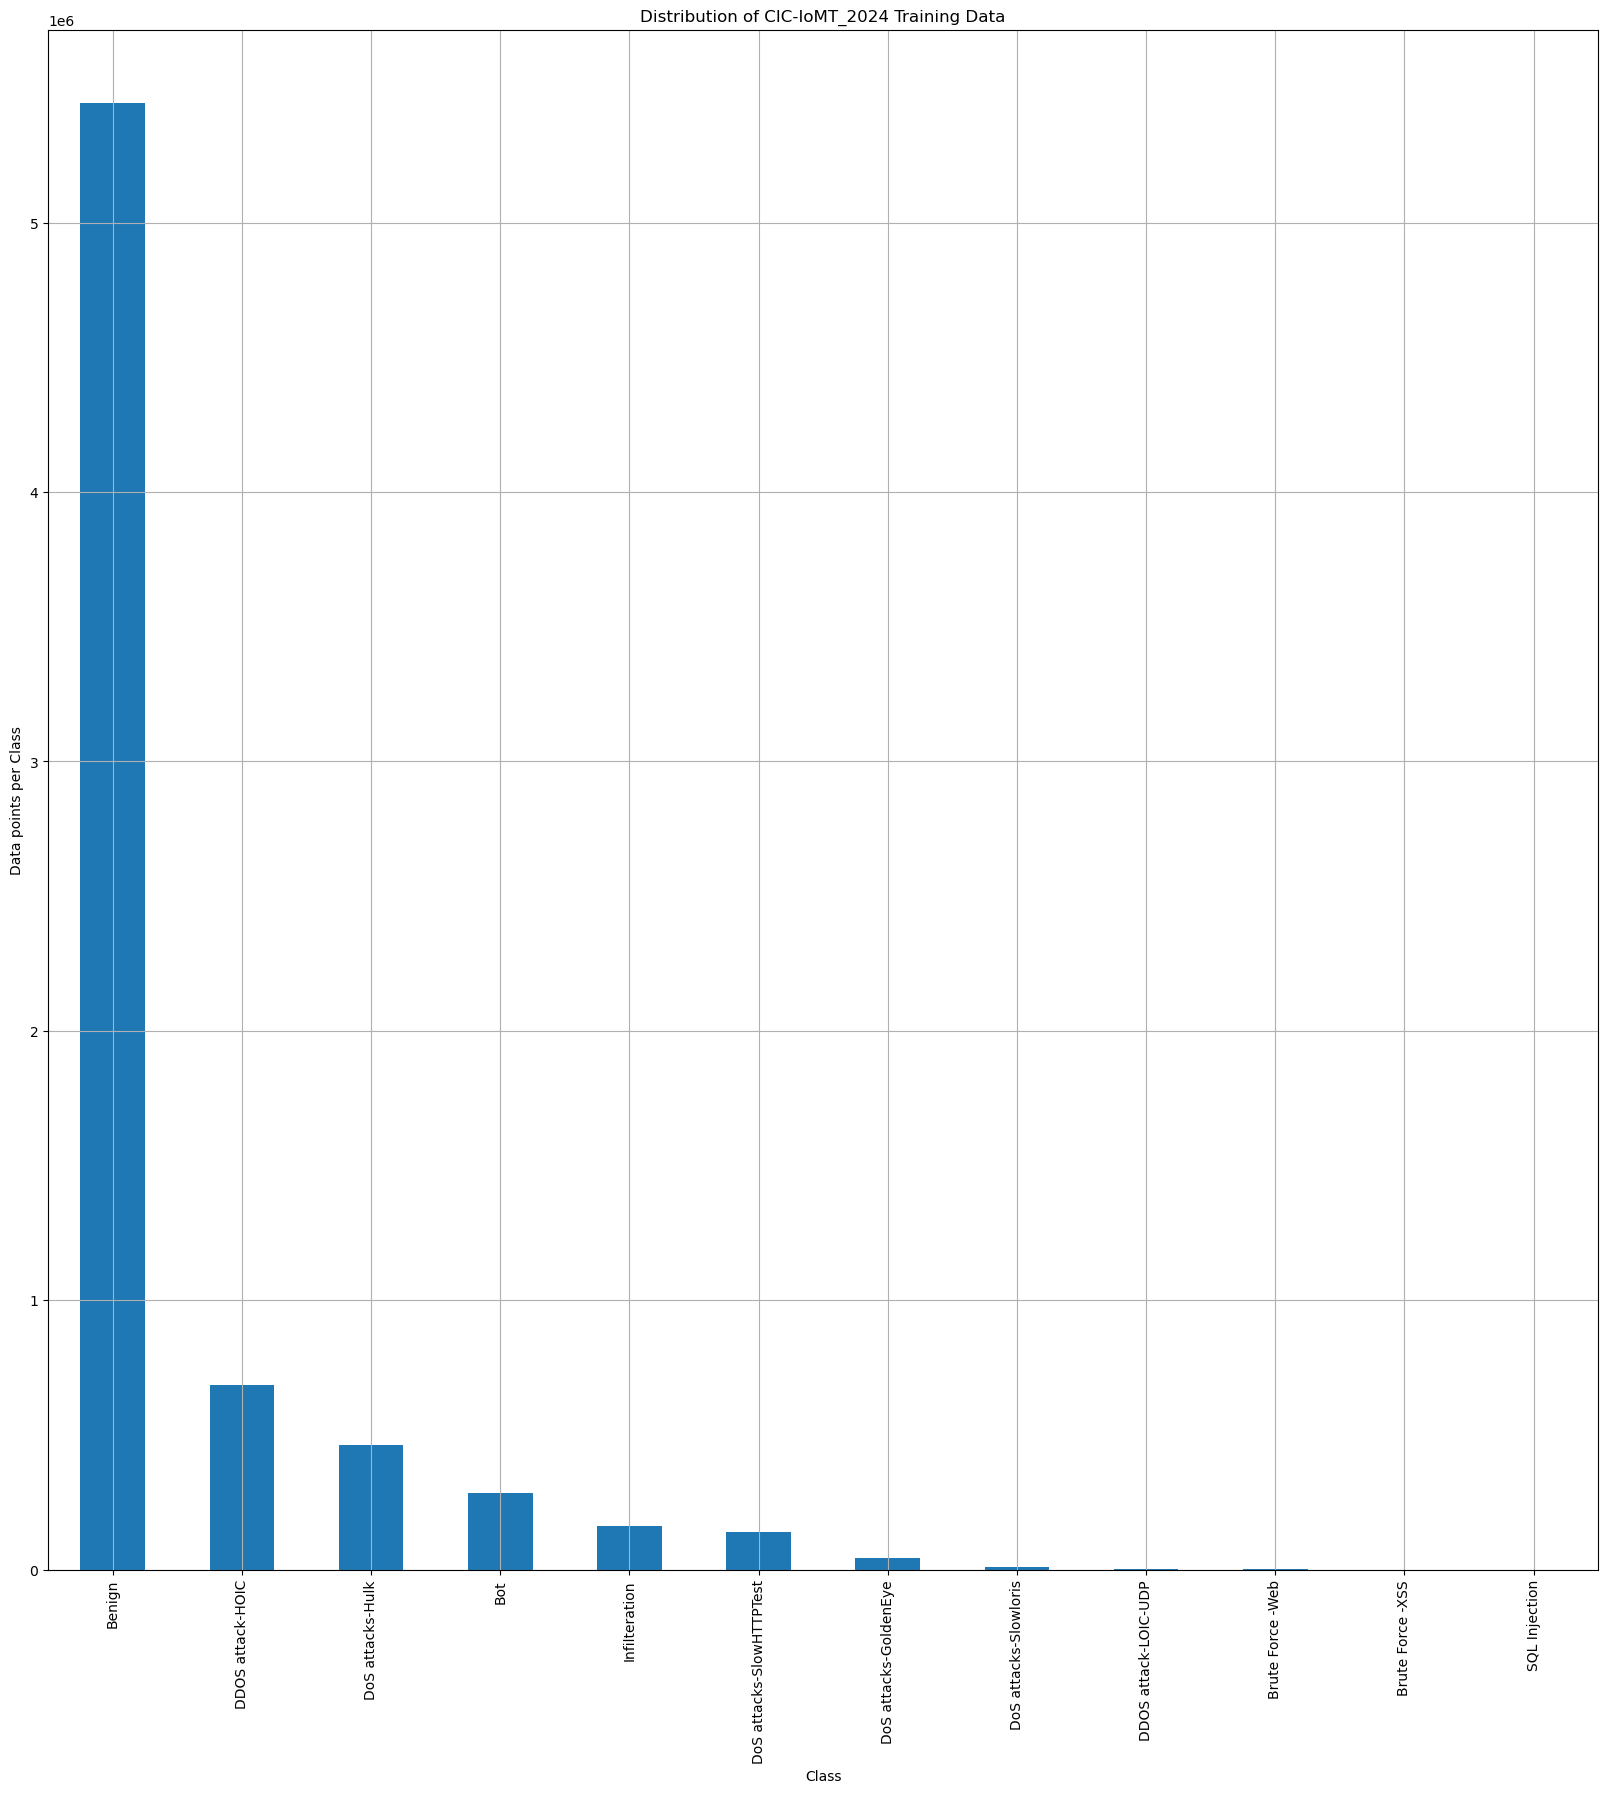

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(20,20))

fig, ax = plt.subplots(figsize=(20,20))
class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of CIC-IoMT_2024 Training Data')
plt.grid()
plt.show()

fig.savefig('CIC-IoT_2023_Data_Distribution.pdf') 

In [15]:
# Before Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class Benign : 5444525 ( 75.246 %)
Number of data points in class DDOS attack-HOIC : 686012 ( 9.481 %)
Number of data points in class DoS attacks-Hulk : 461912 ( 6.384 %)
Number of data points in class Bot : 286191 ( 3.955 %)
Number of data points in class Infilteration : 161934 ( 2.238 %)
Number of data points in class DoS attacks-SlowHTTPTest : 139890 ( 1.933 %)
Number of data points in class DoS attacks-GoldenEye : 41508 ( 0.574 %)
Number of data points in class DoS attacks-Slowloris : 10990 ( 0.152 %)
Number of data points in class DDOS attack-LOIC-UDP : 1730 ( 0.024 %)
Number of data points in class Brute Force -Web : 611 ( 0.008 %)
Number of data points in class Brute Force -XSS : 230 ( 0.003 %)
Number of data points in class SQL Injection : 87 ( 0.001 %)


In [16]:
del sorted_ds

#drop na values and reset index
#data_clean = df.dropna().reset_index()

# Checkng for DUPLICATE values
#data_clean.drop_duplicates(keep='first', inplace = True)

data_clean['Label'].value_counts()

print("Read {} rows.".format(len(data_clean)))

Read 7214943 rows.


In [17]:
analyze(data_clean)


7214943 rows
** index:7214943 (100%)
** flow_duration:2276311 (31%)
** tot_fwd_pkts:3534 (0%)
** tot_bwd_pkts:2527 (0%)
** totlen_fwd_pkts:15086 (0%)
** totlen_bwd_pkts:55856 (0%)
** fwd_pkt_len_max:1495 (0%)
** fwd_pkt_len_min:378 (0%)
** fwd_pkt_len_mean:74876 (1%)
** fwd_pkt_len_std:172162 (2%)
** bwd_pkt_len_max:1453 (0%)
** bwd_pkt_len_min:377 (0%)
** bwd_pkt_len_mean:127820 (1%)
** bwd_pkt_len_std:185297 (2%)
** flow_byts_s:3088543 (42%)
** flow_pkts_s:2753137 (38%)
** flow_iat_mean:2574633 (35%)
** flow_iat_std:3267832 (45%)
** flow_iat_max:1530887 (21%)
** flow_iat_min:417527 (5%)
** fwd_iat_tot:1970492 (27%)
** fwd_iat_mean:2296965 (31%)
** fwd_iat_std:2446852 (33%)
** fwd_iat_max:1575653 (21%)
** fwd_iat_min:502936 (6%)
** bwd_iat_tot:1398003 (19%)
** bwd_iat_mean:1678410 (23%)
** bwd_iat_std:2081006 (28%)
** bwd_iat_max:903930 (12%)
** bwd_iat_min:317698 (4%)
** fwd_psh_flags:[0:96.84%,1:3.16%]
** bwd_psh_flags:[0:100.0%]
** fwd_urg_flags:[0:99.96%,1:0.04%]
** bwd_urg_flags

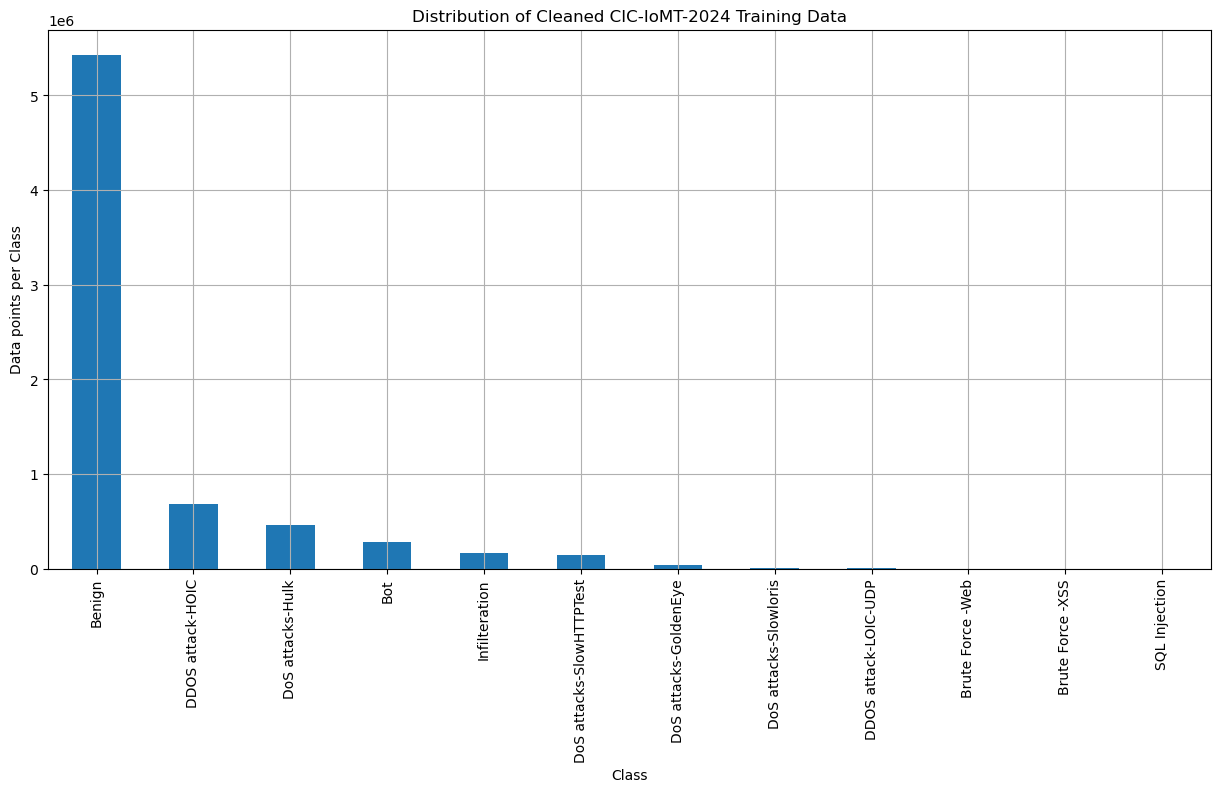

In [18]:
plt.figure(figsize=(15,7))
class_distribution = data_clean['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CIC-IoMT-2024 Training Data')
plt.grid()
plt.show()

In [19]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/data_clean.shape[0]*100), 3), '%)')

Number of data points in class Benign : 5424686 ( 75.187 %)
Number of data points in class DDOS attack-HOIC : 686012 ( 9.508 %)
Number of data points in class DoS attacks-Hulk : 461912 ( 6.402 %)
Number of data points in class Bot : 286191 ( 3.967 %)
Number of data points in class Infilteration : 161096 ( 2.233 %)
Number of data points in class DoS attacks-SlowHTTPTest : 139890 ( 1.939 %)
Number of data points in class DoS attacks-GoldenEye : 41508 ( 0.575 %)
Number of data points in class DoS attacks-Slowloris : 10990 ( 0.152 %)
Number of data points in class DDOS attack-LOIC-UDP : 1730 ( 0.024 %)
Number of data points in class Brute Force -Web : 611 ( 0.008 %)
Number of data points in class Brute Force -XSS : 230 ( 0.003 %)
Number of data points in class SQL Injection : 87 ( 0.001 %)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

0     5424686
4      686012
7      461912
1      286191
10     161096
8      139890
6       41508
9       10990
5        1730
2         611
3         230
11         87
Name: Label, dtype: int64

In [21]:
print(data_clean.shape)

(7214943, 78)


In [22]:
del df

In [23]:
# Convert to numpy array
data_np = data_clean.to_numpy(dtype="float32")

# Drop rows with infinity (inf) values
data_np = data_np[~np.isinf(data_np).any(axis=1)]


# Separate features (X) and target (Y)
X = data_np[:, :-1]  # All columns except the last one
enc = OneHotEncoder()
Y = enc.fit_transform(data_np[:, -1:]).toarray()  # One-hot encode the last column (target)

In [24]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=20, shuffle=True)

# Reshape input features for CNN
_features = X_train.shape[1]  # Number of features
n_classes = Y.shape[1]  # Number of classes in the target
X_train = X_train.reshape(X_train.shape[0], _features, 1)
X_test = X_test.reshape(X_test.shape[0], _features, 1)

_features = X.shape[1]
n_classes = Y.shape[1]

print('X.shape = ',X.shape)
print('Y.shape = ',Y.shape)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',Y_test.shape)

X.shape =  (7203137, 77)
Y.shape =  (7203137, 12)
X_train.shape =  (5402352, 77, 1)
y_train.shape =  (5402352, 12)
X_test.shape =  (1800785, 77, 1)
y_test.shape =  (1800785, 12)


In [25]:
data = data_clean.iloc[:,1:-1]

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [27]:
corr = data.corr()

<AxesSubplot:>

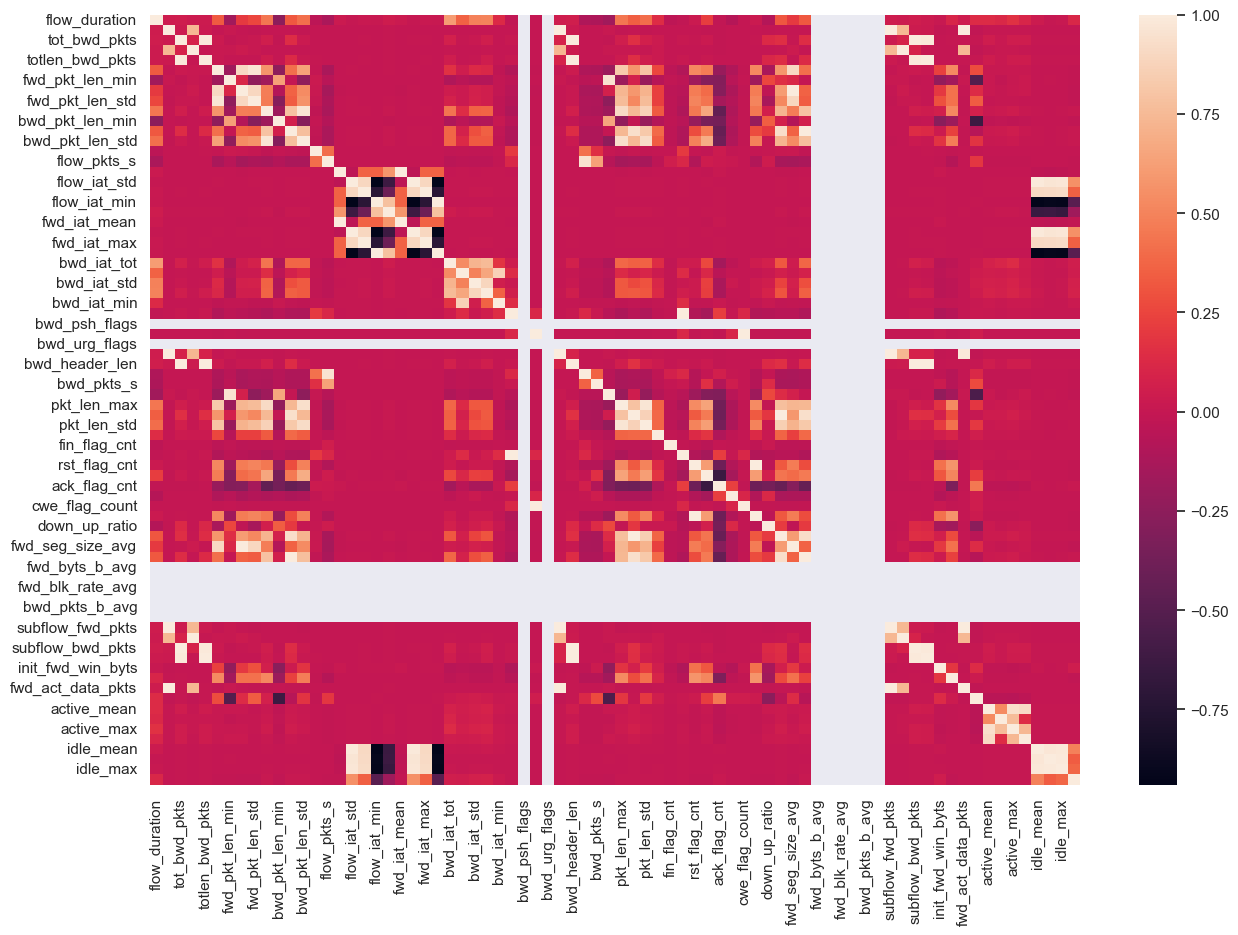

In [28]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr)

# IO-DCNN

In [29]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
     
   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 72, 128)           896       
                                                                 
 conv1d_1 (Conv1D)           (None, 67, 96)            73824     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 67, 96)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 62, 64)            36928     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 3968)              0

In [30]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

56275/56275 [==============================] - 82s 1ms/step
Best loss: 0.03466213867068291
Balanced Acc loss: 82.50107426764525
Learning Rate - 
1e-04


In [31]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

56275/56275 [==============================] - 88s 2ms/step
Completed
Time taken: 0:04:13.491748
Number of Batches: 14069.0
Time per Batch (Inference): 0.007419 seconds
Detection Time per Sample: 0.000058 seconds
Time for fitting: 104.38 seconds
Validation score: 0.9817390749034449
Evaluation score: [0.04235044866800308, 0.9817391037940979]
Recall score: 0.9817390749034449
Precision score: 0.9787620594230024
F1 Measure score: 0.9793700553390201
ROC-AUC score: 0.9100072351640413


In [32]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [33]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 87s 2ms/step


In [34]:
pred.shape
y_test.shape

(1800785,)

In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[1345442,      30,      11,       2,       9,       0,       3,
            421,       1,       4,    7628,       1],
       [     30,   71767,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     54,       0,     111,       3,       0,       0,       0,
              0,       0,       0,       0,       1],
       [      2,       0,      19,      38,       0,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,  171550,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,     428,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,       0,   10343,
              0,       0,       1,       0,       0],
       [      0,       0,       0,       0,       0,       0,       0,
         114934,       0,       0,       0,       0],


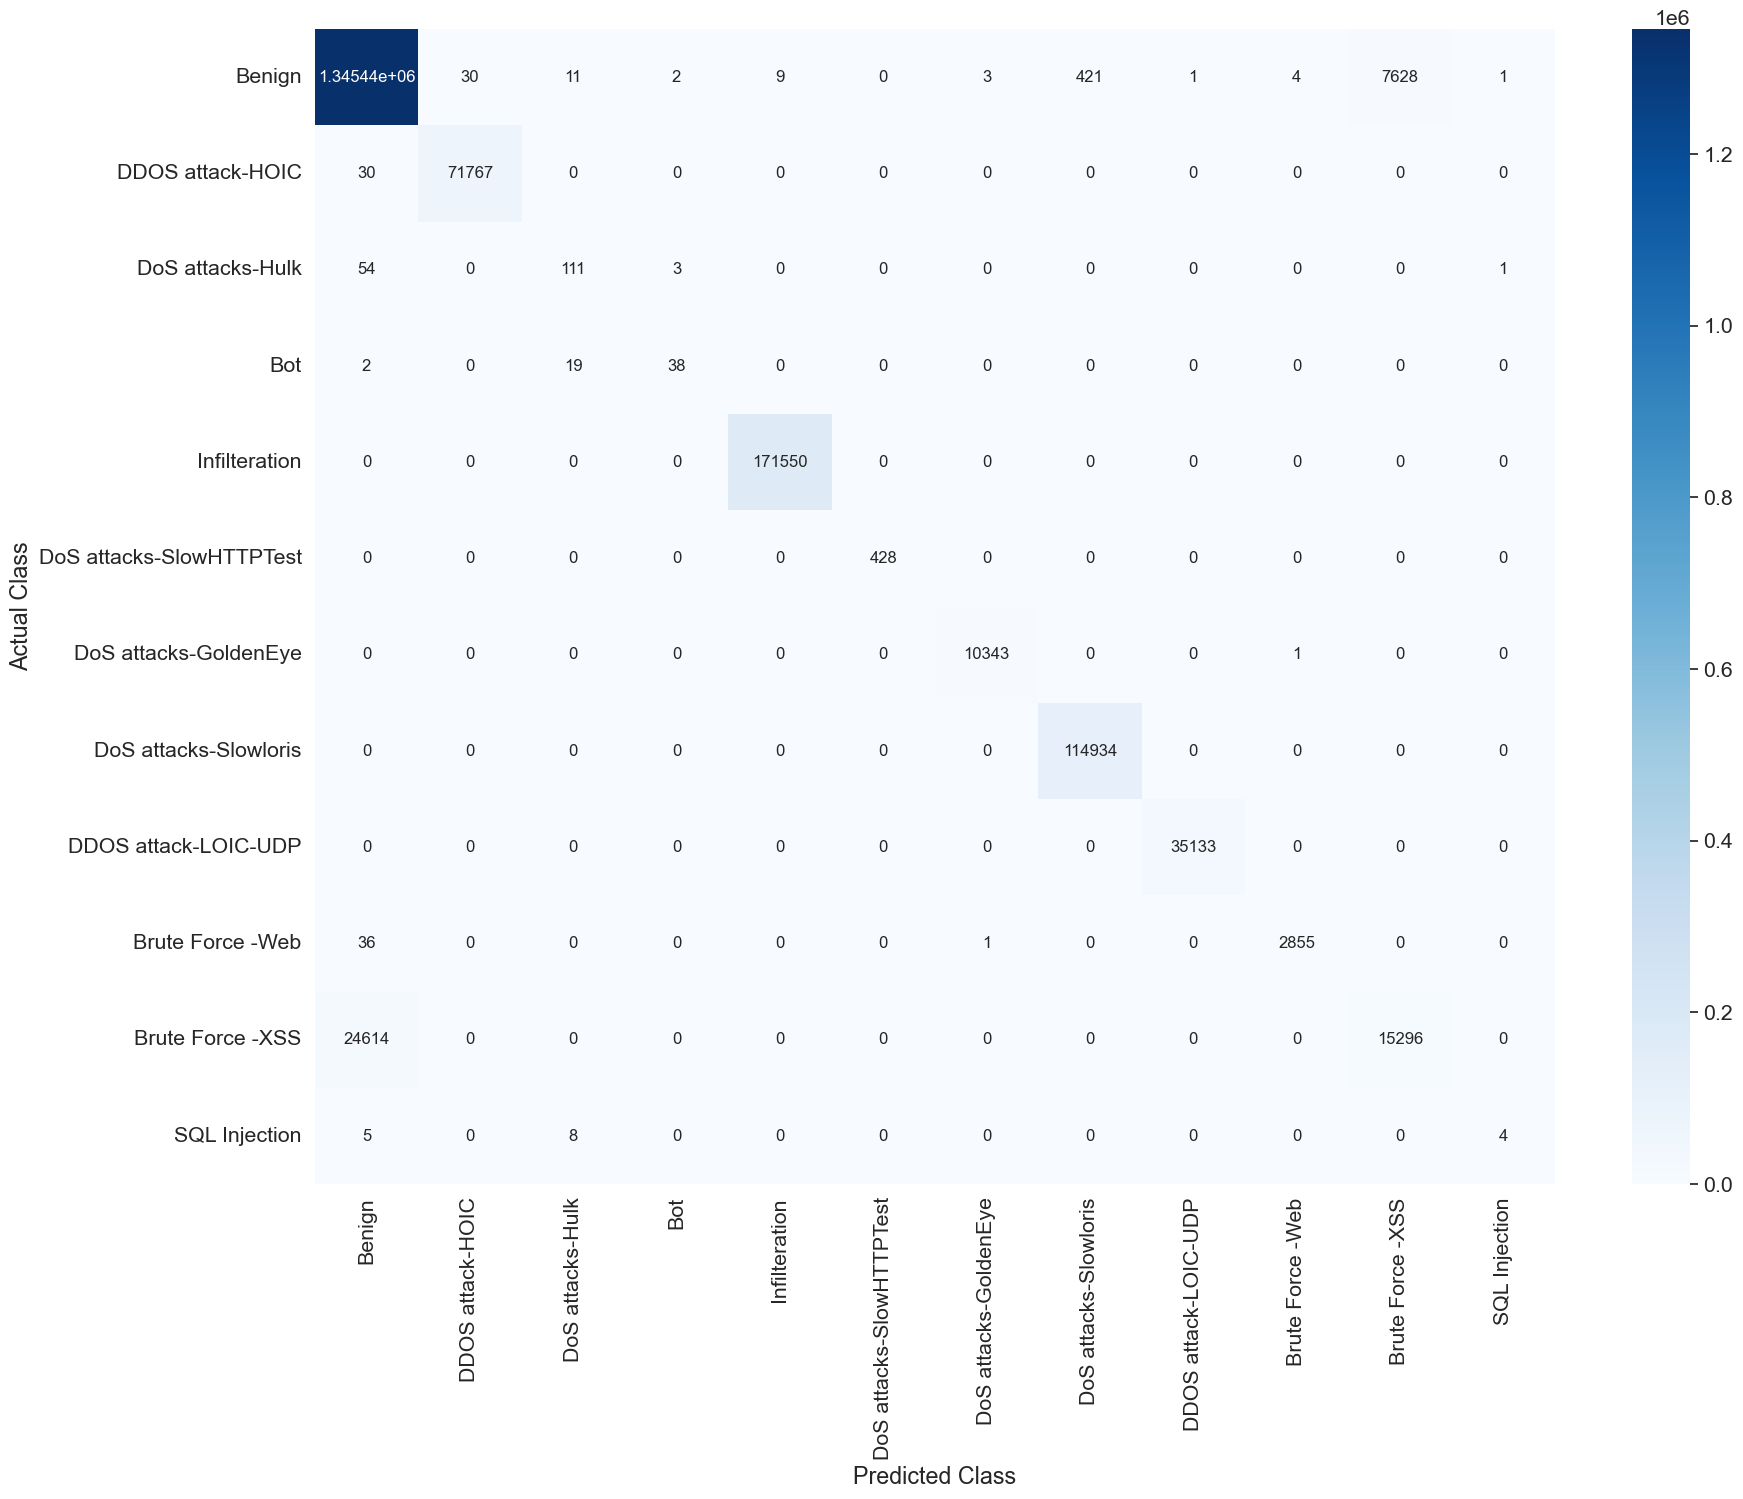

In [36]:
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['Benign','DDOS attack-HOIC','DoS attacks-Hulk','Bot','Infilteration','DoS attacks-SlowHTTPTest',
          'DoS attacks-GoldenEye','DoS attacks-Slowloris','DDOS attack-LOIC-UDP','Brute Force -Web','Brute Force -XSS',
          'SQL Injection']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

# IO-DCNN - Adagrad

In [37]:
K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adagrad(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

   
   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 72, 128)           896       
                                                                 
 conv1d_4 (Conv1D)           (None, 67, 96)            73824     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 67, 96)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 62, 64)            36928     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3968)             

In [38]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

56275/56275 [==============================] - 85s 2ms/step
Best loss: 0.15418323874473572
Balanced Acc loss: 56.201441632019865
Learning Rate - 
1e-04


In [39]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

56275/56275 [==============================] - 87s 2ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:04:10.493306
Number of Batches: 14069.0
Time per Batch (Inference): 0.007274 seconds
Detection Time per Sample: 0.000057 seconds
Time for fitting: 102.34 seconds
Validation score: 0.9524718386703577
Evaluation score: [0.15418580174446106, 0.9524718523025513]
Recall score: 0.9524718386703577
Precision score: 0.942016986326128
F1 Measure score: 0.9382504192833889
ROC-AUC score: 0.7735367260495312


In [40]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 87s 2ms/step


In [41]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[1350143,    1009,       0,       0,    1343,       0,     153,
            671,      60,      12,     161,       0],
       [  37100,   34697,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [    169,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     59,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     12,       0,       0,       0,  171538,       0,       0,
              0,       0,       0,       0,       0],
       [      2,       0,       0,       0,       0,     426,       0,
              0,       0,       0,       0,       0],
       [    482,       0,       0,       0,       0,       0,    6394,
           3458,       0,      10,       0,       0],
       [     14,       0,       0,       0,       0,       0,      53,
         114859,       8,       0,       0,       0],


# IO-DCNN - Adamax

In [42]:
K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adamax(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 72, 128)           896       
                                                                 
 conv1d_7 (Conv1D)           (None, 67, 96)            73824     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 67, 96)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 62, 64)            36928     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3968)             

In [43]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

56275/56275 [==============================] - 86s 2ms/step
Best loss: 0.05335675925016403
Balanced Acc loss: 75.28865269103609
Learning Rate - 
1e-04


In [44]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

56275/56275 [==============================] - 86s 2ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:04:10.603856
Number of Batches: 14069.0
Time per Batch (Inference): 0.007241 seconds
Detection Time per Sample: 0.000057 seconds
Time for fitting: 101.87 seconds
Validation score: 0.9797516083263688
Evaluation score: [0.053357917815446854, 0.9797515869140625]
Recall score: 0.9797516083263688
Precision score: 0.978181437539541
F1 Measure score: 0.972399593736949
ROC-AUC score: 0.8731356586241518


In [45]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 86s 2ms/step


In [46]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[1352283,     155,       0,       0,      51,       0,      14,
            419,       8,      30,     592,       0],
       [     47,   71750,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     95,      11,      63,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     22,       4,       0,      33,       0,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,  171550,       0,       0,
              0,       0,       0,       0,       0],
       [      2,       0,       0,       0,       0,     426,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,       0,   10341,
              0,       0,       3,       0,       0],
       [      0,       0,       0,       0,       0,       0,       0,
         114934,       0,       0,       0,       0],


# IO-DCNN - Nadam

In [47]:
K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Nadam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 72, 128)           896       
                                                                 
 conv1d_10 (Conv1D)          (None, 67, 96)            73824     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 67, 96)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 62, 64)            36928     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3968)             

In [48]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

56275/56275 [==============================] - 86s 2ms/step
Best loss: 0.029788583517074585
Balanced Acc loss: 84.25198304395214
Learning Rate - 
1e-04


In [49]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

56275/56275 [==============================] - 88s 2ms/step
Completed
Time taken: 0:04:15.976337
Number of Batches: 14069.0
Time per Batch (Inference): 0.007425 seconds
Detection Time per Sample: 0.000058 seconds
Time for fitting: 104.47 seconds
Validation score: 0.9880424370482873
Evaluation score: [0.029790354892611504, 0.988042414188385]
Recall score: 0.9880424370482873
Precision score: 0.9875063708027703
F1 Measure score: 0.9864077952611527
ROC-AUC score: 0.919395888319583


In [50]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 88s 2ms/step


In [51]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[1351529,      38,      27,       4,      16,       0,       7,
            418,       4,      16,    1493,       0],
       [     25,   71772,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     51,       0,     115,       2,       0,       0,       0,
              0,       0,       0,       0,       1],
       [      1,       0,      17,      41,       0,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,  171550,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,     428,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,       0,   10344,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,       0,       0,
         114934,       0,       0,       0,       0],


# IO-DCNN - SGD

In [52]:
K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.SGD(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

   
   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test)) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 72, 128)           896       
                                                                 
 conv1d_13 (Conv1D)          (None, 67, 96)            73824     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 67, 96)           0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 62, 64)            36928     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3968)             

In [53]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

56275/56275 [==============================] - 79s 1ms/step
Best loss: 0.14817769825458527
Balanced Acc loss: 55.71023614983637
Learning Rate - 
1e-04


In [54]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

56275/56275 [==============================] - 77s 1ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:03:40.287386
Number of Batches: 14069.0
Time per Batch (Inference): 0.006577 seconds
Detection Time per Sample: 0.000051 seconds
Time for fitting: 92.53 seconds
Validation score: 0.9516494195586924
Evaluation score: [0.14817415177822113, 0.9516494274139404]
Recall score: 0.9516494195586924
Precision score: 0.9408223521489024
F1 Measure score: 0.9373687211018984
ROC-AUC score: 0.7710483540630388


In [55]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 76s 1ms/step


In [56]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[1349233,    1826,       0,       0,    1287,       0,     290,
            682,      62,      15,     157,       0],
       [  37107,   34690,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [    169,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     59,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     18,       0,       0,       0,  171532,       0,       0,
              0,       0,       0,       0,       0],
       [      2,       0,       0,       0,       0,     426,       0,
              0,       0,       0,       0,       0],
       [    446,       0,       0,       0,       0,       0,    5777,
           4116,       0,       5,       0,       0],
       [      6,       0,       0,       0,       0,       0,       1,
         114916,      11,       0,       0,       0],
